In [ ]:
%pip install earthengine-api

In [29]:
%matplotlib inline

In [5]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [6]:
import ee

# Re-initialize just in case
ee.Initialize()

# Define the bounding box roughly over Siberia
siberia = ee.Geometry.Rectangle([60, 57, 140, 72])  # (lon_min, lat_min, lon_max, lat_max)

# Time range
start_date = '2013-01-01'
end_date = '2023-12-31'

In [8]:
# Load MODIS Albedo data
modis_albedo = ee.ImageCollection("MODIS/006/MCD43A3") \
    .filterDate(start_date, end_date) \
    .filterBounds(siberia)

# Print how many images were found
print("Number of images:", modis_albedo.size().getInfo())

Number of images: 3693


In [9]:
def summer_mean(year):
    start = ee.Date.fromYMD(year, 6, 1)
    end = ee.Date.fromYMD(year, 8, 31)
    summer = modis_albedo.filterDate(start, end)
    return summer.mean().set('year', year)

# Generate yearly summer means from 2000 to 2022
years = list(range(2000, 2023))
summer_means = ee.ImageCollection([summer_mean(y) for y in years])

In [13]:
def get_monthly_albedo(year, month, region):
    # Format month as '01', '02', etc.
    month_str = str(month).zfill(2)
    start = ee.Date(f"{year}-{month_str}-01")
    end = start.advance(1, 'month')

    collection = ee.ImageCollection("MODIS/006/MCD43A3") \
        .filterDate(start, end) \
        .filterBounds(region) \
        .select('Albedo_WSA_shortwave')

    monthly_mean = collection.mean().set({
        'year': year,
        'month': month,
        'label': 'snow' if month in [12, 1, 2] else 'leaf' if month in [6, 7, 8] else 'transition'
    })

    return monthly_mean

In [14]:
years = list(range(2001, 2021))
months = list(range(1, 13))

monthly_albedo_images = []

for year in years:
    for month in months:
        img = get_monthly_albedo(year, month, siberia)
        monthly_albedo_images.append(img)

# Create an image collection
monthly_albedo_ic = ee.ImageCollection(monthly_albedo_images)

In [15]:
task = ee.batch.Export.table.toDrive(
    collection=monthly_albedo_ic,
    description='Monthly_Albedo_Stats',
    fileFormat='CSV'
)
task.start()

In [ ]:
import pandas as pd

df = pd.read_csv('Monthly_Albedo_Stats.csv')
df.head()

In [ ]:
# Make sure 'label', 'year', and 'mean' exist
df['year'] = df['year'].astype(int)
df['label'] = df['label'].astype(str)

# Group by year and season label
seasonal_means = df.groupby(['year', 'label'])['mean'].mean().unstack()
seasonal_means.plot(kind='line', title='Seasonal Albedo Trends')

In [21]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'snow'
    elif month in [6, 7, 8]:
        return 'leaf'
    else:
        return 'transition'
def compute_mean_albedo(image):
    # Get image date info
    date = ee.Date(image.get('system:time_start'))
    year = date.get('year')
    month = date.get('month')
    
    # Reduce region to get mean albedo over Siberia
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=siberia,
        scale=500,
        maxPixels=1e13
    )
    
    # Add results as properties
    return ee.Feature(None, {
        'mean_albedo': mean_dict.get('Albedo_WSA_shortwave'),
        'year': year,
        'month': month,
        'season': get_season_from_month(month)
    })
def get_season_from_month(month):
    # This wraps our Python logic into EE expression logic
    return ee.Algorithms.If(
        ee.Number(month).eq(12).Or(ee.Number(month).lte(2)), 'snow',
        ee.Algorithms.If(
            ee.Number(month).gte(6).And(ee.Number(month).lte(8)), 'leaf',
            'transition'
        )
    )
features = modis_albedo.map(compute_mean_albedo)
task = ee.batch.Export.table.toDrive(
    collection=features,
    description='Siberia_Monthly_Albedo',
    fileFormat='CSV'
)
task.start()

In [ ]:
import pandas as pd

albedo_df = pd.read_csv("Siberia_Albedo_Seasonal.csv")  # Replace with your actual filename
print(albedo_df)

In [ ]:
alb_monthly_avg = albedo_df.groupby('month')['mean_albedo'].mean().reset_index()
print(alb_monthly_avg)

In [ ]:
seasonal_avg = albedo_df.groupby('season')['mean_albedo'].mean().reset_index()
print(seasonal_avg)

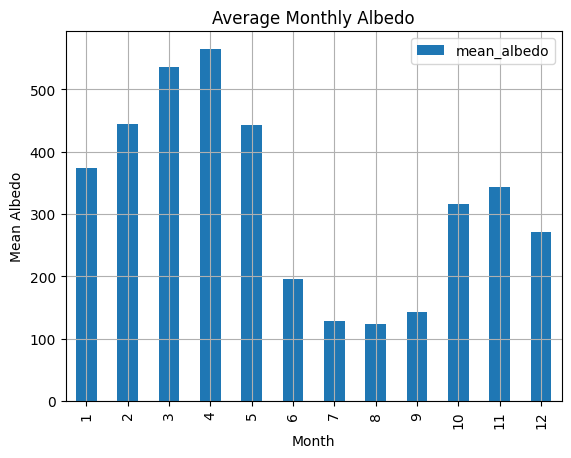

In [62]:
import matplotlib.pyplot as plt

alb_monthly_avg.plot(x='month', y='mean_albedo', kind='bar')
plt.title('Average Monthly Albedo')
plt.xlabel('Month')
plt.ylabel('Mean Albedo')
plt.grid(True)
plt.show()

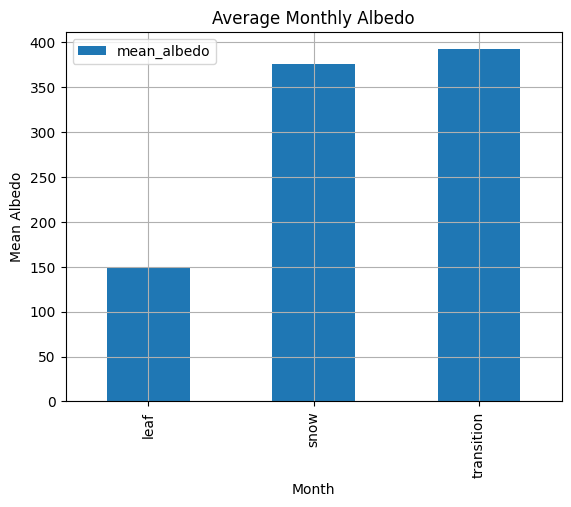

In [63]:
import matplotlib.pyplot as plt

seasonal_avg.plot(x='season', y='mean_albedo', kind='bar')
plt.title('Average Monthly Albedo')
plt.xlabel('Month')
plt.ylabel('Mean Albedo')
plt.grid(True)
plt.show()

In [ ]:
import xarray as xr
import pandas as pd

# Load NetCDF
ds = xr.open_dataset("CERES_EBAF_TOA_OLR_Siberia.nc")

# Inspect variable names
print(ds.data_vars)

# Extract OLR (this might be named like 'toa_lw_all_mon')
olr = ds['toa_lw_all_mon']
olr_clr=ds['toa_lw_clr_c_mon']
# Mean over lat/lon
monthly_olr = olr.mean(dim=['lat', 'lon'])
monthly_olr_clr=olr_clr.mean(dim=['lat', 'lon'])
# Convert to DataFrame
olr_df = monthly_olr.to_dataframe().reset_index()
olr_clr_df =monthly_olr_clr.to_dataframe().reset_index()
# Add month/year columns
olr_df['month'] = olr_df['time'].dt.month
olr_df['year'] = olr_df['time'].dt.year
olr_clr_df['month'] = olr_clr_df['time'].dt.month
olr_clr_df['year'] = olr_clr_df['time'].dt.year
# Optional: Monthly average across years
olr_monthly_avg = olr_df.groupby('month')['toa_lw_all_mon'].mean().reset_index()
print(olr_monthly_avg)
olr_clr_monthly_avg = olr_clr_df.groupby('month')['toa_lw_clr_c_mon'].mean().reset_index()

In [ ]:
import xarray as xr
import pandas as pd

# Load NetCDF
ds = xr.open_dataset("CERES_EBAF_TOA_OLR_Siberia.nc")

# Inspect variable names
print(ds.data_vars)

# Extract OLR (this might be named like 'toa_lw_all_mon')
sol = ds['solar_mon']
# Mean over lat/lon
monthly_sol= sol.mean(dim=['lat', 'lon'])
# Convert to DataFrame
solar_df = monthly_sol.to_dataframe().reset_index()
# Add month/year columns
solar_df['month'] = solar_df['time'].dt.month
solar_df['year'] = solar_df['time'].dt.year
# Optional: Monthly average across years
sol_monthly_avg = solar_df.groupby('month')['solar_mon'].mean().reset_index()

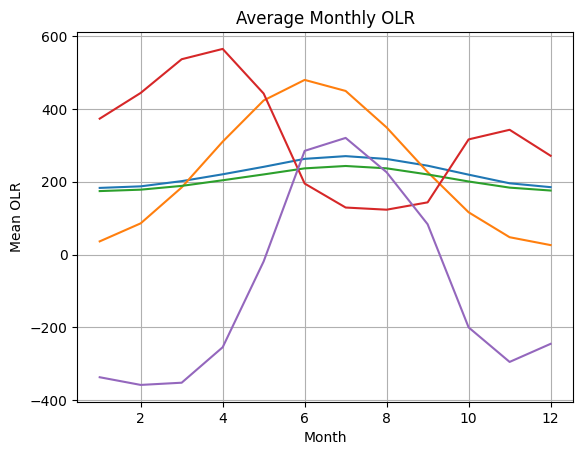

In [66]:
import matplotlib.pyplot as plt

# olr_monthly_avg.plot(x='month', y='toa_lw_all_mon', kind='bar')
# alb_monthly_avg.plot(x='month', y='mean_albedo', kind='bar')
plt.plot(olr_clr_monthly_avg['month'],olr_clr_monthly_avg['toa_lw_clr_c_mon'])
plt.plot(sol_monthly_avg['month'],sol_monthly_avg['solar_mon'])
plt.plot(olr_monthly_avg['month'],olr_monthly_avg['toa_lw_all_mon'])
plt.plot(alb_monthly_avg['month'],alb_monthly_avg['mean_albedo'])
plt.plot(sol_monthly_avg['month'],sol_monthly_avg['solar_mon']-alb_monthly_avg['mean_albedo'])
plt.title('Average Monthly OLR')
plt.xlabel('Month')
plt.ylabel('Mean OLR')
plt.grid(True)
plt.show()

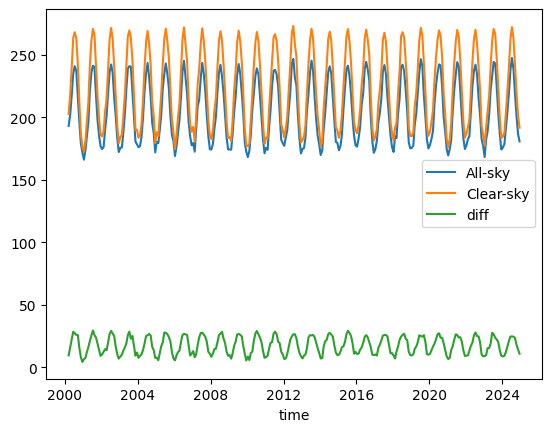

In [80]:
ds['toa_lw_all_mon'].mean(dim=['lat', 'lon']).plot(label='All-sky')
ds['toa_lw_clr_c_mon'].mean(dim=['lat', 'lon']).plot(label='Clear-sky')
diff=ds['toa_lw_clr_c_mon'].mean(dim=['lat', 'lon'])-ds['toa_lw_all_mon'].mean(dim=['lat', 'lon'])
diff.plot(label='diff')
plt.legend()

In [68]:
# Example for albedo
albedo_yearly = albedo_df.groupby('year')['mean_albedo'].mean().reset_index()

# OLR (all-sky)
olr_yearly = olr_df.groupby('year')['toa_lw_all_mon'].mean().reset_index()

# Solar flux (optional)
solar_yearly = solar_df.groupby('year')['solar_mon'].mean().reset_index()

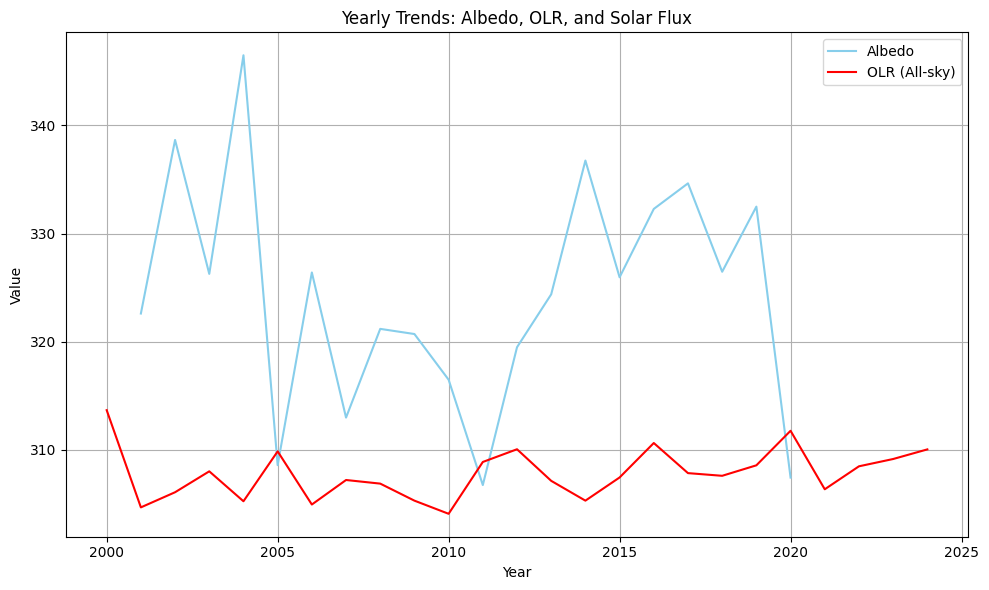

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(albedo_yearly['year'], albedo_yearly['mean_albedo'], label='Albedo', color='skyblue')
plt.plot(olr_yearly['year'], olr_yearly['toa_lw_all_mon']*1.5, label='OLR (All-sky)', color='red')

plt.title('Yearly Trends: Albedo, OLR, and Solar Flux')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import ee
ee.Initialize()

# Define your region (reuse Siberia polygon)
siberia = ee.Geometry.Rectangle([60, 57, 140, 72])  # Adjust if needed

# Load MODIS NDVI dataset
modis_ndvi = ee.ImageCollection("MODIS/006/MOD13A2") \
    .filterBounds(siberia) \
    .select('NDVI')

# Function to calculate annual mean NDVI
def annual_ndvi(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    return modis_ndvi.filterDate(start, end).mean() \
        .set('year', year)

# Generate images from 2001 to 2021
years = ee.List.sequence(2001, 2021)
annual_ndvi_ic = ee.ImageCollection(years.map(annual_ndvi))

In [73]:
# Function to get mean NDVI per year
def reduce_to_mean(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=siberia,
        scale=1000,
        maxPixels=1e13
    )
    return ee.Feature(None, {
        'year': image.get('year'),
        'mean_ndvi': stats.get('NDVI')
    })

# Map and collect as feature collection
ndvi_fc = annual_ndvi_ic.map(reduce_to_mean)

In [74]:
task = ee.batch.Export.table.toDrive(
    collection=ndvi_fc,
    description='Annual_NDVI_Siberia',
    fileFormat='CSV'
)
task.start()

In [ ]:
import pandas as pd

ndvi_df = pd.read_csv('Annual_NDVI_Siberia.csv')
ndvi_df['year'] = ndvi_df['year'].astype(int)
print(ndvi_df)

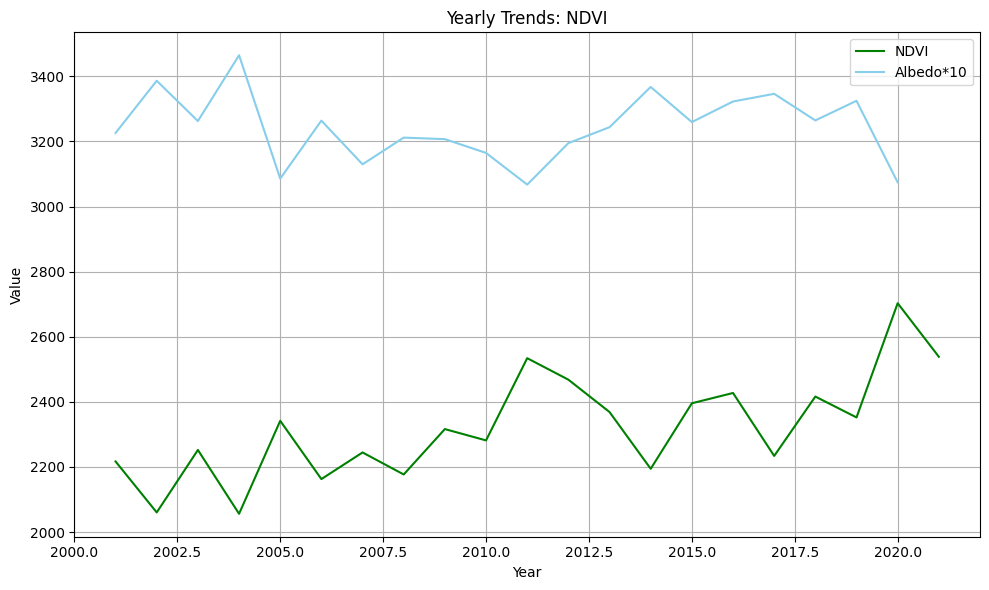

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(ndvi_df['year'], ndvi_df['mean_ndvi'], label='NDVI', color='green')
plt.plot(albedo_yearly['year'], albedo_yearly['mean_albedo']*10, label='Albedo*10', color='skyblue')

plt.title('Yearly Trends: NDVI')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
landcover = ee.ImageCollection("MODIS/006/MCD12Q1") \
    .filterBounds(siberia) \
    .filterDate('2001-01-01', '2021-12-31') \
    .select('LC_Type1')

c:\Users\ritob\AppData\Local\Programs\Python\Python311\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MCD12Q1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1

  warnings.warn(warning, category=DeprecationWarning)


In [85]:
def green_cover_fraction(image):
    year = ee.Date(image.get('system:time_start')).get('year')
    
    green_classes = [1, 2, 3, 4, 5, 6, 7]  # Forests, shrubland, grassland
    green_mask = image.remap(green_classes, [1]*len(green_classes), 0).rename('green_mask')

    area_image = green_mask.multiply(ee.Image.pixelArea())

    green_area = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=siberia,
        scale=500,
        maxPixels=1e13
    ).get('green_mask')  # use the new name

    return ee.Feature(None, {
        'year': year,
        'green_area_m2': green_area
    })

In [87]:
features = landcover.map(green_cover_fraction)

task = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection(features),
    description='MODIS_LandCover_GreenArea_Siberia',
    fileFormat='CSV'
)
task.start()

In [89]:
lc_df = pd.read_csv('MODIS_LandCover_GreenArea_Siberia.csv')
lc_df['year'] = lc_df['year'].astype(int)
lc_df['green_area_km2'] = lc_df['green_area_m2'] / 1e6  # Convert to km²
print(lc_df)

   system:index  green_area_m2  year                                    .geo  \
0    2001_01_01   2.112749e+12  2001  {"type":"MultiPoint","coordinates":[]}   
1    2002_01_01   2.110497e+12  2002  {"type":"MultiPoint","coordinates":[]}   
2    2003_01_01   2.108784e+12  2003  {"type":"MultiPoint","coordinates":[]}   
3    2004_01_01   2.112708e+12  2004  {"type":"MultiPoint","coordinates":[]}   
4    2005_01_01   2.115948e+12  2005  {"type":"MultiPoint","coordinates":[]}   
5    2006_01_01   2.116355e+12  2006  {"type":"MultiPoint","coordinates":[]}   
6    2007_01_01   2.118388e+12  2007  {"type":"MultiPoint","coordinates":[]}   
7    2008_01_01   2.122689e+12  2008  {"type":"MultiPoint","coordinates":[]}   
8    2009_01_01   2.133688e+12  2009  {"type":"MultiPoint","coordinates":[]}   
9    2010_01_01   2.140471e+12  2010  {"type":"MultiPoint","coordinates":[]}   
10   2011_01_01   2.134941e+12  2011  {"type":"MultiPoint","coordinates":[]}   
11   2012_01_01   2.120771e+12  2012  {"

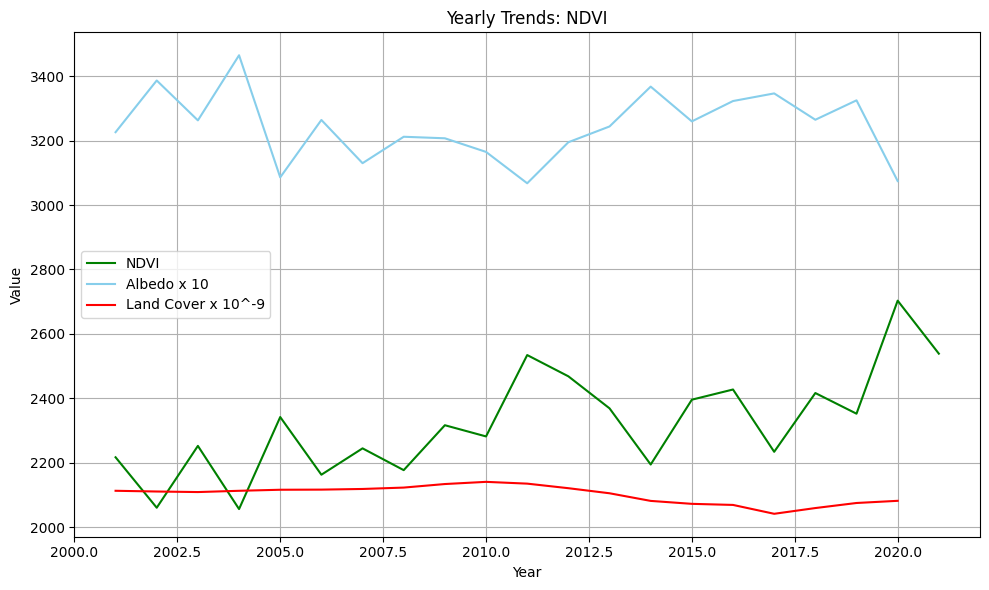

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(ndvi_df['year'], ndvi_df['mean_ndvi'], label='NDVI', color='green')
plt.plot(albedo_yearly['year'], albedo_yearly['mean_albedo']*10, label='Albedo x 10', color='skyblue')
plt.plot(lc_df['year'], lc_df['green_area_m2']/(10**9), label='Land Cover x 10^-9', color='red')
plt.title('Yearly Trends: NDVI')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()